### Loading names

In [1]:
words = open('names.txt','r').read().splitlines()

In [3]:
len(words)

32033

In [4]:
words[:5]

['emma', 'olivia', 'ava', 'isabella', 'sophia']

### Creating stoi and itos for ys

In [8]:
chars = sorted(list(set(''.join(words))) + ['.'])

In [10]:
len(chars)

27

In [12]:
stoi_ys = {i:e for e,i in enumerate(chars)}

In [14]:
itos_ys = {v:k for k,v in stoi_ys.items()}

In [16]:
stoi_ys

{'.': 0,
 'a': 1,
 'b': 2,
 'c': 3,
 'd': 4,
 'e': 5,
 'f': 6,
 'g': 7,
 'h': 8,
 'i': 9,
 'j': 10,
 'k': 11,
 'l': 12,
 'm': 13,
 'n': 14,
 'o': 15,
 'p': 16,
 'q': 17,
 'r': 18,
 's': 19,
 't': 20,
 'u': 21,
 'v': 22,
 'w': 23,
 'x': 24,
 'y': 25,
 'z': 26}

### Creating stoi and itos of xs

In [19]:
from itertools import product

In [21]:
stoi_xs = {}
for e,(ch1,ch2) in enumerate(product(chars,repeat=2)):
    ch = ch1+ch2
    stoi_xs[ch] = e 
    

In [23]:
len(stoi_xs)

729

In [25]:
itos_xs = {v:k for k,v in stoi_xs.items()}

In [27]:
# stoi_xs

### Creating training set of trigrams

In [30]:
import torch

In [31]:
num_words = len(words)

In [34]:
import random
random.seed(42)
random.shuffle(words)

In [36]:
train = int(0.8*num_words)
dev = int(0.1*num_words)
train_words = words[:train]
dev_words = words[train: train+dev]
test_words = words[train+dev:]

In [38]:
assert len(train_words) + len(dev_words) + len(test_words) == num_words

In [40]:
len(train_words), len(dev_words), len(test_words)

(25626, 3203, 3204)

In [42]:
def words_to_modelling_data(words):
    xs,ys = [],[]
    
    printed=False
    for w in words:
        chs = ['.'] + list(w) + ['.']
        for i in range(len(chs)-2):
            ch1 = chs[i] + chs[i+1]
            ch2 = chs[i+2]
                
            ix1 = stoi_xs[ch1]
            ix2 = stoi_ys[ch2]
            if not printed:
                print('first trigram :')
                print(ch1,ch2)
                print(ix1,ix2)
                printed=True
            xs.append(ix1)
            ys.append(ix2)
                               
    xs = torch.tensor(xs, dtype=torch.long)
    ys = torch.tensor(ys, dtype=torch.long)
    return xs, ys

In [44]:
xs,ys = words_to_modelling_data(train_words)

first trigram :
.y u
25 21


In [46]:
xs_dev,ys_dev = words_to_modelling_data(dev_words)

first trigram :
.a m
1 13


In [48]:
xs_test,ys_test = words_to_modelling_data(test_words)

first trigram :
.m u
13 21


In [50]:
len(xs), len(ys)

(156999, 156999)

In [56]:
len(xs_dev), len(ys_dev)

(19452, 19452)

In [63]:
len(xs_test), len(ys_test)

(19662, 19662)

### Doing a single trigram pass

In [66]:
import torch.nn.functional as F

In [68]:
xenc = F.one_hot(xs, num_classes=729).float()

In [70]:
xenc.shape

torch.Size([156999, 729])

In [72]:
g = torch.Generator().manual_seed(42)
W = torch.randn((729,27), generator=g)

In [74]:
logits = xenc @ W
count = logits.exp()
probs = count / count.sum(dim=1, keepdims=True)

In [76]:
probs.shape

torch.Size([156999, 27])

In [78]:
xs[0].item()

25

In [80]:
itos_xs[xs[0].item()],itos_ys[ys[0].item()]

('.y', 'u')

In [82]:
probs[0,ys[0].item()]

tensor(0.0129)

### Training the trigram neural net

In [291]:
import matplotlib.pyplot as plt
%matplotlib inline

In [293]:
def train_gram_model(xenc, ys, xenc_dev, ys_dev):
    losses=[]
    losses_dev=[]
    rounds=0
    for iterations in range(max_rounds):
        logits = xenc @ W
        count = logits.exp()
        probs = count / count.sum(dim=1, keepdims=True)
        loss = -probs[torch.arange(xenc.shape[0]), ys].log().mean() + smoothing*(W**2).mean()
        losses.append(loss.item())
        rounds+=1
        
        #dev loss
        with torch.no_grad():
            logits = xenc_dev @ W
            count = logits.exp()
            probs = count / count.sum(dim=1, keepdims=True)
            loss_dev = -probs[torch.arange(xenc_dev.shape[0]), ys_dev].log().mean()
            losses_dev.append(loss_dev.item())
    
        if (rounds==1) | (rounds%100==0):
            print(f'Rounds : {rounds} | Train Loss : {loss.item():.2f} | | Dev Loss : {loss_dev.item():.2f}')

        if iterations<(max_rounds-1):
            W.grad = None
            loss.backward()
            W.data += -learning_rate * W.grad
        

In [295]:
for smoothing in [0.001,0.01,1,10]:
    print(f"--------------------Smoothing : {smoothing}--------------------")
    max_rounds=500
    learning_rate = 50
    # smoothing=0.01
    xenc = F.one_hot(xs, num_classes=729).float()
    xenc_dev = F.one_hot(xs_dev, num_classes=729).float()
    xenc_test = F.one_hot(xs_test, num_classes=729).float()
    g = torch.Generator().manual_seed(42)
    W = torch.randn((729,27), generator=g, requires_grad=True)
    train_gram_model(xenc, ys, xenc_dev, ys_dev)

--------------------Smoothing : 0.001--------------------
Rounds : 1 | Train Loss : 3.71 | | Dev Loss : 3.71
Rounds : 100 | Train Loss : 2.40 | | Dev Loss : 2.41
Rounds : 200 | Train Loss : 2.26 | | Dev Loss : 2.28
Rounds : 300 | Train Loss : 2.21 | | Dev Loss : 2.22
Rounds : 400 | Train Loss : 2.18 | | Dev Loss : 2.19
Rounds : 500 | Train Loss : 2.16 | | Dev Loss : 2.17
--------------------Smoothing : 0.01--------------------
Rounds : 1 | Train Loss : 3.72 | | Dev Loss : 3.71
Rounds : 100 | Train Loss : 2.41 | | Dev Loss : 2.41
Rounds : 200 | Train Loss : 2.27 | | Dev Loss : 2.28
Rounds : 300 | Train Loss : 2.22 | | Dev Loss : 2.22
Rounds : 400 | Train Loss : 2.19 | | Dev Loss : 2.19
Rounds : 500 | Train Loss : 2.17 | | Dev Loss : 2.17
--------------------Smoothing : 1--------------------
Rounds : 1 | Train Loss : 4.71 | | Dev Loss : 3.71
Rounds : 100 | Train Loss : 2.82 | | Dev Loss : 2.41
Rounds : 200 | Train Loss : 2.57 | | Dev Loss : 2.32
Rounds : 300 | Train Loss : 2.49 | | Dev L

In [296]:
losses=[]
losses_dev=[]
rounds=0
max_rounds=500
learning_rate = 50
smoothing=0.01
xenc = F.one_hot(xs, num_classes=729).float()
xenc_dev = F.one_hot(xs_dev, num_classes=729).float()
xenc_test = F.one_hot(xs_test, num_classes=729).float()
g = torch.Generator().manual_seed(42)
W = torch.randn((729,27), generator=g, requires_grad=True)
for iterations in range(max_rounds):
    logits = xenc @ W
    count = logits.exp()
    probs = count / count.sum(dim=1, keepdims=True)
    loss = -probs[torch.arange(xenc.shape[0]), ys].log().mean() + smoothing*(W**2).mean()
    losses.append(loss.item())
    rounds+=1
    
    #dev loss
    with torch.no_grad():
        logits = xenc_dev @ W
        count = logits.exp()
        probs = count / count.sum(dim=1, keepdims=True)
        loss_dev = -probs[torch.arange(xenc_dev.shape[0]), ys_dev].log().mean()
        losses_dev.append(loss_dev.item())

    if (rounds==1) | (rounds%100==0):
        print(f'Rounds : {rounds} | Train Loss : {loss.item():.2f} | | Dev Loss : {loss_dev.item():.2f}')

    if iterations<(max_rounds-1):
        W.grad = None
        loss.backward()
        W.data += -learning_rate * W.grad
    

Rounds : 1 | Train Loss : 3.72 | | Dev Loss : 3.71
Rounds : 100 | Train Loss : 2.41 | | Dev Loss : 2.41
Rounds : 200 | Train Loss : 2.27 | | Dev Loss : 2.28
Rounds : 300 | Train Loss : 2.22 | | Dev Loss : 2.22
Rounds : 400 | Train Loss : 2.19 | | Dev Loss : 2.19
Rounds : 500 | Train Loss : 2.17 | | Dev Loss : 2.17


Text(0, 0.5, 'Losses')

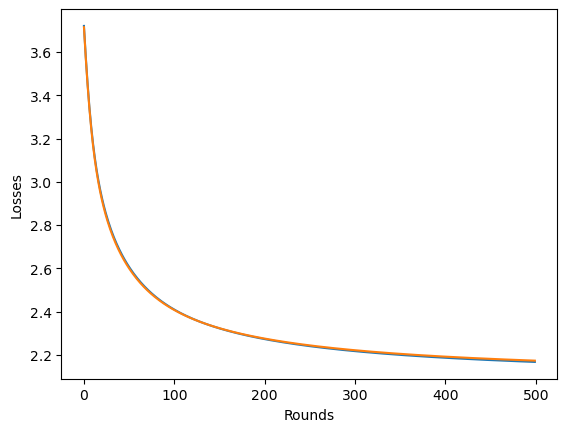

In [298]:
plt.plot(range(len(losses)), losses,label='train')
plt.plot(range(len(losses_dev)), losses_dev,label='dev')
plt.xlabel('Rounds')
plt.ylabel('Losses')

### Evaluation

In [299]:
xenc_dev.shape, xenc_test.shape

(torch.Size([19452, 729]), torch.Size([19662, 729]))

In [300]:
def evaluate(xenc, ys):
    logits = xenc @ W
    count = logits.exp()
    probs = count / count.sum(dim=1, keepdims=True)
    loss = -probs[torch.arange(xenc.shape[0]), ys].log().mean()
    return round(loss.item(),2)

In [301]:
evaluate(xenc, ys)

2.16

In [302]:
evaluate(xenc_dev, ys_dev)

2.17

In [303]:
evaluate(xenc_test, ys_test)

2.18

### Remove OHE to train the model & applying cross entropy

In [364]:
F.cross_entropy(probs[torch.arange(len(xs_dev))], ys_dev)

tensor(3.1478)

In [400]:
logits.shape

torch.Size([19452, 27])

In [416]:
torch.tensor([50]).exp().log()

tensor([50.])

In [422]:
logits.shape

torch.Size([19452, 27])

In [424]:
losses=[]
losses_dev=[]
rounds=0
max_rounds=500
learning_rate = 50
smoothing=0.01
# xenc = F.one_hot(xs, num_classes=729).float()
# xenc_dev = F.one_hot(xs_dev, num_classes=729).float()
# xenc_test = F.one_hot(xs_test, num_classes=729).float()
g = torch.Generator().manual_seed(42)
W = torch.randn((729,27), generator=g, requires_grad=True)
for iterations in range(max_rounds):
    logits = W[xs]
    # count = logits.exp()
    # probs = count / count.sum(dim=1, keepdims=True)
    # loss = -probs[torch.arange(len(xs)), ys].log().mean() + smoothing*(W**2).mean()
    loss = F.cross_entropy(logits,ys) + smoothing*(W**2).mean()
    
    losses.append(loss.item())
    rounds+=1
    
    #dev loss
    with torch.no_grad():
        logits =  W[xs_dev]
        # count = logits.exp()
        # probs = count / count.sum(dim=1, keepdims=True)
        # loss_dev = -probs[torch.arange(len(xs_dev)), ys_dev].log().mean()
        loss_dev = F.cross_entropy(logits,ys_dev)
        losses_dev.append(loss_dev.item())

    if (rounds==1) | (rounds%100==0):
        print(f'Rounds : {rounds} | Train Loss : {loss.item():.2f} | | Dev Loss : {loss_dev.item():.2f}')

    if iterations<(max_rounds-1):
        W.grad = None
        loss.backward()
        W.data += -learning_rate * W.grad
    

Rounds : 1 | Train Loss : 3.72 | | Dev Loss : 3.71
Rounds : 100 | Train Loss : 2.41 | | Dev Loss : 2.41
Rounds : 200 | Train Loss : 2.27 | | Dev Loss : 2.28
Rounds : 300 | Train Loss : 2.22 | | Dev Loss : 2.22
Rounds : 400 | Train Loss : 2.19 | | Dev Loss : 2.19
Rounds : 500 | Train Loss : 2.17 | | Dev Loss : 2.17


### CPU vs GPU

In [453]:
from time import time

In [457]:
for device in [torch.device('cpu'), torch.device('mps')]:
    tic = time()
    losses=[]
    losses_dev=[]
    rounds=0
    max_rounds=10000
    learning_rate = 50
    smoothing=0.01
    xs = xs.to(device)
    ys = ys.to(device)
    xs_dev = xs_dev.to(device)
    ys_dev = ys_dev.to(device)
    g = torch.Generator(device=device).manual_seed(42)
    W = torch.randn((729,27), generator=g, requires_grad=True, device=device)
    for iterations in range(max_rounds):
        logits = W[xs]
        # count = logits.exp()
        # probs = count / count.sum(dim=1, keepdims=True)
        # loss = -probs[torch.arange(len(xs)), ys].log().mean() + smoothing*(W**2).mean()
        loss = F.cross_entropy(logits,ys) + smoothing*(W**2).mean()
        
        losses.append(loss.item())
        rounds+=1
        
        #dev loss
        with torch.no_grad():
            logits =  W[xs_dev]
            # count = logits.exp()
            # probs = count / count.sum(dim=1, keepdims=True)
            # loss_dev = -probs[torch.arange(len(xs_dev)), ys_dev].log().mean()
            loss_dev = F.cross_entropy(logits,ys_dev)
            losses_dev.append(loss_dev.item())
    
        if (rounds==1) | (rounds%1000==0):
            print(f'Rounds : {rounds} | Train Loss : {loss.item():.2f} | | Dev Loss : {loss_dev.item():.2f}')
    
        if iterations<(max_rounds-1):
            W.grad = None
            loss.backward()
            W.data += -learning_rate * W.grad
    
    toc = time()
    
    print(f"**********TIME TAKEN for {device} : {round(toc-tic,2)}s**********")
    

Rounds : 1 | Train Loss : 3.72 | | Dev Loss : 3.71
Rounds : 1000 | Train Loss : 2.13 | | Dev Loss : 2.13
Rounds : 2000 | Train Loss : 2.10 | | Dev Loss : 2.12
Rounds : 3000 | Train Loss : 2.10 | | Dev Loss : 2.11
Rounds : 4000 | Train Loss : 2.09 | | Dev Loss : 2.11
Rounds : 5000 | Train Loss : 2.09 | | Dev Loss : 2.10
Rounds : 6000 | Train Loss : 2.09 | | Dev Loss : 2.10
Rounds : 7000 | Train Loss : 2.09 | | Dev Loss : 2.10
Rounds : 8000 | Train Loss : 2.09 | | Dev Loss : 2.10
Rounds : 9000 | Train Loss : 2.09 | | Dev Loss : 2.10
Rounds : 10000 | Train Loss : 2.09 | | Dev Loss : 2.10
**********TIME TAKEN for cpu : 66.97s**********
Rounds : 1 | Train Loss : 3.78 | | Dev Loss : 3.77
Rounds : 1000 | Train Loss : 2.13 | | Dev Loss : 2.13
Rounds : 2000 | Train Loss : 2.10 | | Dev Loss : 2.11
Rounds : 3000 | Train Loss : 2.10 | | Dev Loss : 2.11
Rounds : 4000 | Train Loss : 2.09 | | Dev Loss : 2.11
Rounds : 5000 | Train Loss : 2.09 | | Dev Loss : 2.10
Rounds : 6000 | Train Loss : 2.09 | | D

### Predictions

In [93]:
{k:v for k,v in stoi_xs.items() if k[0] == '.' if k[1] != '.'} # valid starting bigrams

{'.a': 1,
 '.b': 2,
 '.c': 3,
 '.d': 4,
 '.e': 5,
 '.f': 6,
 '.g': 7,
 '.h': 8,
 '.i': 9,
 '.j': 10,
 '.k': 11,
 '.l': 12,
 '.m': 13,
 '.n': 14,
 '.o': 15,
 '.p': 16,
 '.q': 17,
 '.r': 18,
 '.s': 19,
 '.t': 20,
 '.u': 21,
 '.v': 22,
 '.w': 23,
 '.x': 24,
 '.y': 25,
 '.z': 26}

In [841]:
g = torch.Generator().manual_seed(99)
N = 20
for xs_input_i in torch.randint(low=1, high=27, size=(N,),generator=g): # get a valid starting bigram
    xs_input_i = xs_input_i.item()
    xs_input_s = itos_xs[xs_input_i]
    out = [xs_input_s]
    while True:
        xenc_inf = F.one_hot(torch.tensor([xs_input_i]), num_classes=729).float()
        logits = xenc_inf @ W
        count = logits.exp()
        probs = count / count.sum(dim=1, keepdims=True)
        ys_output_i = torch.multinomial(probs, num_samples=1, replacement=True, generator=g).item()
        ys_output_s = itos_ys[ys_output_i] # using itos_ys instead itos_xs
        out.append(ys_output_s)  
        if ys_output_s == '.':
            break
        xs_input_i = stoi_xs[''.join(out)[-2] + ''.join(out)[-1]]
    print(''.join(out)[1:-1])

brawilyn
xydenehi
daikalyn
yab
xan
quinois
quigh
cor
ta
quilly
fexan
xmck
maelory
dem
jhana
brisofina
dasir
kaee
rekiyah
dalotalyn
